In [2]:
import os
import cv2 as cv 
import numpy as np 
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input, Conv2DTranspose, concatenate

In [3]:
def getDataSetAsDir(Dir):
    traindsPath = Dir
    trainMasks = []
    trainImages = []
    for roots, dirs, files in os.walk(traindsPath):
        list_roots = roots.split('/')
        if list_roots[-1] == 'masks':
            files = [os.path.join(roots, file) for file in files]
            trainMasks.append((files))
        if list_roots[-1] == 'images':
            files = [os.path.join(roots, file) for file in files]
            trainImages.append((files))
    return trainImages, trainMasks

In [4]:
def readImage(path):
    image = cv.imread(path, 1)
    image = cv.resize(image, (96, 96))
    return image

In [5]:
def addMasks(masks):
    addImage = np.zeros((96, 96, 1), dtype=np.uint8)
    for maskIds in range(0, len(masks)):
        image = cv.imread(masks[maskIds], 0)
        image = cv.resize(image, (96, 96))
        image = cv.add(addImage, image)
        addImage = image
    return addImage

In [6]:
def showImage(image):
    plt.imshow(image, plt.cm.binary)
    plt.show()

In [7]:
def createDS(x, y):
    traindsPath = []
    for ds in zip(x, y):
        traindsPath.append(ds)
    return traindsPath

In [8]:
def normalize(ds):
    DS = []
    for i in ds:
        DS.append(i/255)
    return DS

In [9]:
traindsPath = '../DataSet/trainds'
trainImagesDir, trainMasksDir = getDataSetAsDir(traindsPath)

In [10]:
trainImages = []
for trainImagePath in trainImagesDir:
    image = readImage(trainImagePath[0])
    trainImages.append(image)

In [11]:
trainMasks = []
for trainMaskPath in trainMasksDir:
    image = addMasks(trainMaskPath)
    trainMasks.append(image)

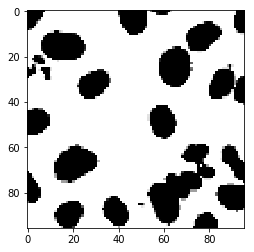

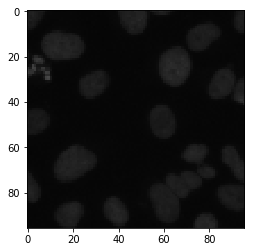

In [12]:
showImage(trainMasks[0])
showImage(trainImages[0])

In [13]:
trainMasks[0].shape

(96, 96)

In [14]:
trainMasksNormalized= np.array(normalize(trainMasks))
trainImagesNormalized = np.array(normalize(trainImages))

In [15]:
trainMasksNormalized.shape

(670, 96, 96)

In [16]:
reshapedMasks = []
for i in trainMasksNormalized:
    i = np.expand_dims(i, axis=3)
    reshapedMasks.append(i)

/home/sammyview80/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
reshapedMasks = np.array(reshapedMasks)

In [18]:
reshapedMasks[0].shape

(96, 96, 1)

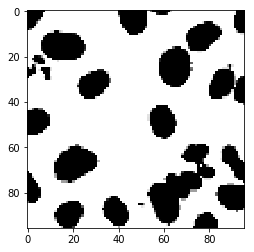

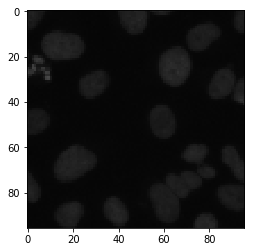

In [19]:
showImage(trainMasksNormalized[0])
showImage(trainImagesNormalized[0])

In [20]:
trainds = tf.data.Dataset.from_tensor_slices((trainImagesNormalized, trainMasksNormalized))

In [21]:
trainds

<TensorSliceDataset shapes: ((96, 96, 3), (96, 96)), types: (tf.float64, tf.float64)>

In [22]:
for i in trainds.take(1):
    print(i)

(<tf.Tensor: shape=(96, 96, 3), dtype=float64, numpy=
array([[[0.10588235, 0.10588235, 0.10588235],
        [0.11764706, 0.11764706, 0.11764706],
        [0.12156863, 0.12156863, 0.12156863],
        ...,
        [0.09019608, 0.09019608, 0.09019608],
        [0.10196078, 0.10196078, 0.10196078],
        [0.11372549, 0.11372549, 0.11372549]],

       [[0.10980392, 0.10980392, 0.10980392],
        [0.1254902 , 0.1254902 , 0.1254902 ],
        [0.13333333, 0.13333333, 0.13333333],
        ...,
        [0.09803922, 0.09803922, 0.09803922],
        [0.10588235, 0.10588235, 0.10588235],
        [0.12156863, 0.12156863, 0.12156863]],

       [[0.10980392, 0.10980392, 0.10980392],
        [0.10980392, 0.10980392, 0.10980392],
        [0.12941176, 0.12941176, 0.12941176],
        ...,
        [0.10980392, 0.10980392, 0.10980392],
        [0.11764706, 0.11764706, 0.11764706],
        [0.12156863, 0.12156863, 0.12156863]],

       ...,

       [[0.02352941, 0.02352941, 0.02352941],
        [0.023

In [23]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchNormal=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchNormal:
        x = BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchNormal:
        x = BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

In [24]:
def get_unet(input_img, n_filters=12, dropout=0.5, batchNormal=True):
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchNormal=batchNormal)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout*0.5)(p1)
    
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchNormal=batchNormal)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchNormal=batchNormal)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchNormal=batchNormal)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchNormal=batchNormal)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchNormal=batchNormal)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchNormal=batchNormal)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchNormal=batchNormal)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchNormal=batchNormal)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = tf.keras.models.Model(inputs=[input_img], outputs=[outputs])
    return model

In [25]:
input_img = Input((96, 96, 3), name='img')
model = get_unet(input_img, n_filters=12, dropout=0.05, batchNormal=True)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 12)   336         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 96, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

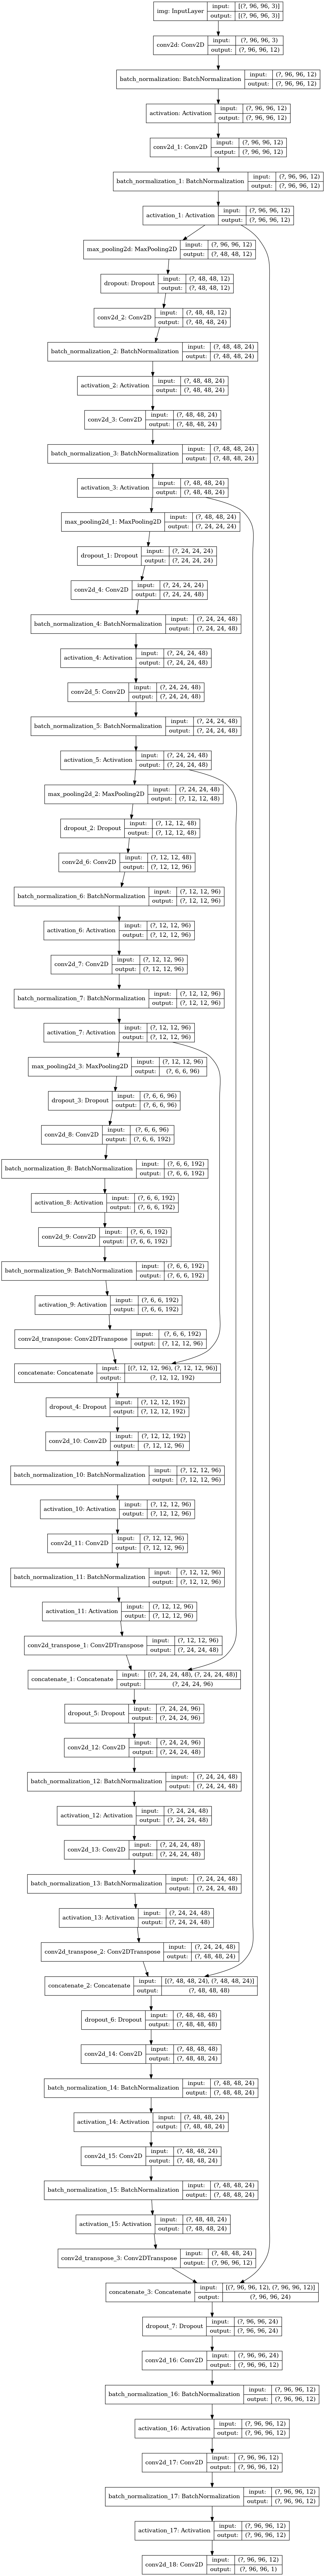

In [26]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [67]:
model.fit(trainImagesNormalized,reshapedMasks, verbose=1, epochs=2)

Train on 670 samples
Epoch 1/2
670/670 [==============================] - 27s 40ms/sample - loss: 0.4621 - accuracy: 0.8230
Epoch 2/2
670/670 [==============================] - 24s 36ms/sample - loss: 0.3115 - accuracy: 0.9122


In [68]:
model.save('unet.h5')

In [69]:
model = tf.keras.models.load_model('unet.h5')

In [78]:
def predict(imagePath):
    imagePredict = readImage(imagePath)
    showImage(imagePredict.squeeze())
    imagePredict = imagePredict.reshape(1, 96, 96, 3)
    prediction = model.predict(imagePredict)
    showImage(prediction.squeeze())

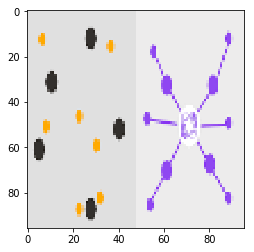

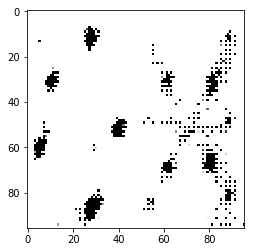

In [79]:
predict('./test.png')

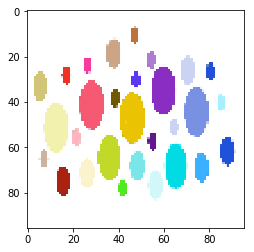

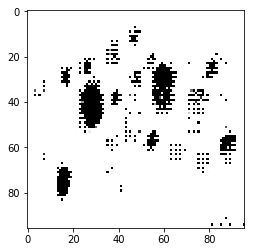

In [80]:
predict('./test1.png')

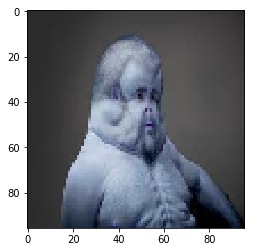

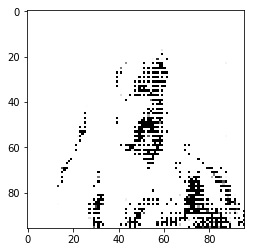

In [82]:
predict('./test2.png')